# 质量控制

## 动机

单细胞RNA测序数据集有两个重要的属性，进行分析时应牢记这两点。首先，scRNA-seq数据是drop-out数据，意味着由于限制mRNA，数据中有大量的零。其次，由于数据可能与生物学混淆，纠正数据和进行质量控制的可能性可能受限。因此，选择适合基础数据的预处理方法，而不过度纠正或移除生物效应至关重要。

由于新的测序技术和捕获细胞、测量基因和识别细胞种群数量的增加，单细胞RNA测序数据分析的工具集正在快速发展。许多这些工具致力于预处理，旨在解决以下分析步骤：双细胞检测、质量控制、规范化、特征选择和降维。在本章中选择的工具可以严重影响数据的后续分析和解释。例如，如果你在质量控制过程中过滤掉了太多的细胞，你可能会失去稀有的细胞亚群，并错过对有趣的细胞生物学的洞察。而如果你过于宽松，如果你在预处理流程中没有排除质量差的细胞，你可能会在注释你的细胞时遇到困难。因此，选择能提供最佳实践并在下游任务中表现优于其他工具的工具是重要的。在许多情况下，你仍然需要重新评估你的预处理分析并改变，例如，过滤策略。

这个笔记本的起点是已经按照原始处理章节中以前描述的方式处理过的单细胞数据。数据被对齐以获得分子计数矩阵，即所谓的计数矩阵，或读取计数（读取矩阵）。计数和读取矩阵之间的差异取决于是否在单细胞文库构建协议中包含了唯一的分子标识符（UMIs）。读取和计数矩阵的维度是条形码数量x转录本数量。需要注意的是，这里使用的术语"条形码"代替了"细胞"，因为一个条形码可能错误地标记了多个细胞（双细胞），或可能没有标记任何细胞（空滴液/孔）。我们将在"双细胞检测"这一节中对此进行更深入的讨论。

## 环境准备和数据

我们使用为NeurIPS 2021会议的单细胞数据整合挑战生成的10x 多组学数据集。该数据集捕获了来自12个健康人类供体的骨髓单核细胞的单细胞多组学数据，测量了四个不同的位置以获得嵌套的批次效应。在本教程中，我们将使用该数据集中的一个批次，即供体8的样本4，展示scRNA-seq数据预处理的最佳实践。

虽然单细胞计数矩阵的预处理通常是一个相当线性的过程，在这个过程中各种质量控制和预处理步骤按照明确的顺序进行，但是这里的特定步骤的引入要求我们有时跳跃到我们将在稍后的子章节中引入的步骤。例如，我们利用聚类进行环境RNA修正，但只会在后面介绍聚类。

作为第一步，我们先使用scanpy从figshare加载数据集。

In [1]:
import numpy as np
import scanpy as sc
import seaborn as sns
from scipy.stats import median_abs_deviation

sc.settings.verbosity = 0
sc.settings.set_figure_params(
    dpi=80,
    facecolor="white",
    frameon=False,
)

In [2]:
adata = sc.read_10x_h5(
    filename="filtered_feature_bc_matrix.h5",
    backup_url="https://figshare.com/ndownloader/files/39546196",
)
adata

/mnt/sdd/singleron_product/chenjin/miniconda3/envs/scanpy/lib/python3.10/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


AnnData object with n_obs × n_vars = 16934 × 36601
    var: 'gene_ids', 'feature_types', 'genome'

读取数据后，scanpy显示警告，表示不是所有变量名称都是唯一的。这表明一些变量（=基因）出现了多次，这可能会导致下游分析任务出现错误或意外行为。我们执行建议的函数`var_names_make_unique()`，通过将一个数字字符串附加到每个重复的索引元素（'1'、'2'等）来使变量名唯一。

In [3]:
adata.var_names_make_unique()
adata

AnnData object with n_obs × n_vars = 16934 × 36601
    var: 'gene_ids', 'feature_types', 'genome'

数据集的形状为`n_obs` 16,934 x `n_vars` 36,601。这转化为`barcode x 转录本数`。我们还通过`var`查看了有关gene_ids（Ensembl Id）、feature_types和genome的进一步信息。

大多数后续分析任务假定数据集中的每个obs都代表来自一个完整的单个细胞的测量。在某些情况下，这个假设可能会被违反，例如低质量细胞、细胞外RNA的污染或双细胞。本教程将指导您如何纠正和删除这些违规，并获得高质量的数据集。

![Ambient RNA Overview](https://www.sc-best-practices.org/_images/quality_control.jpeg)
单细胞RNA-seq数据集可能包含低质量细胞、细胞外RNA和双细胞。质量控制旨在删除和纠正这些问题，以获得每个obs都是完整单个细胞的高质量数据集。

##  过滤低质量序列

质量控制的第一步是从数据集中删除低质量序列。当一个细胞检测到的基因数较少、计数深度较低、线粒体计数的比例较高时，可能表示该细胞的膜破裂，表明它是一个死亡的细胞。由于这些细胞通常不是我们分析的主要目标，可能会扭曲我们的下游分析，因此我们在质量控制期间将它们删除。为了识别它们，我们定义了细胞质量控制（QC）阈值。在细胞QC中，通常通过以下三个QC协变量进行过滤：

1. 每个条形码的计数数（计数深度）
2. 每个条形码的基因数
3. 每个条形码来自线粒体基因的计数比例

在细胞QC中，这些协变量通过阈值过滤，因为它们可能对应于死亡细胞。如上所述，它们可能反映出具有破裂膜的细胞，其细胞质mRNA泄漏出来，因此只有线粒体中的mRNA仍然存在。这些细胞可能显示出低计数深度、少数检测到的基因和高线粒体读数的特征。然而，考虑三个QC协变量的联合是至关重要的，否则可能导致细胞信号的误解。例如，具有相对较高线粒体计数的细胞可能参与呼吸过程，不应被过滤掉。而计数低或高的细胞可能对应于休眠细胞群体或体积较大的细胞。因此，在做出单个协变量的阈值决策时，最好考虑多个协变量。一般来说，建议排除较少的细胞，并尽可能宽松，以避免过滤掉可行的细胞群体或小的子群体。

对于仅有少量或小型数据集的QC，通常通过查看不同QC协变量的分布并识别异常值来手动进行。然而，随着数据集的增大，这个任务变得越来越耗时，因此值得考虑通过MAD（中位数绝对偏差）进行自动阈值设置。MAD由MAD=median(|Xi−median(X)|)给出，其中Xi是观测值的相应QC指标，描述了指标的可变性的一个稳健统计量。与(Germain *et al.*，2020)类似，如果细胞相差5个MAD，则将其标记为异常值，这是一种相对宽松的过滤策略。我们想强调的是，在细胞注释之后重新评估过滤可能是合理的。

在QC中，第一步是计算QC协变量或指标。我们使用scanpy函数`sc.pp.calculate_qc_metrics`计算这些指标，该函数还可以计算特定基因群体的计数比例。因此，我们定义了线粒体、核糖体和血红蛋白基因。重要的是要注意，线粒体计数根据数据集中考虑的物种而注释为前缀“mt-”或“MT-”。如上所述，本笔记本中使用的数据集是人类骨髓，因此线粒体计数以前缀“MT-”注释。对于小鼠数据集，前缀通常是小写的“mt-”。

In [4]:
# mitochondrial genes
adata.var["mt"] = adata.var_names.str.startswith("MT-")
# ribosomal genes
adata.var["ribo"] = adata.var_names.str.startswith(("RPS", "RPL"))
# hemoglobin genes.
adata.var["hb"] = adata.var_names.str.contains(("^HB[^(P)]"))

现在，我们可以使用scanpy计算相应的QC指标。

In [5]:
sc.pp.calculate_qc_metrics(
    adata, qc_vars=["mt", "ribo", "hb"], inplace=True, percent_top=[20], log1p=True
)
adata

AnnData object with n_obs × n_vars = 16934 × 36601
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'

如我们所见，该函数向`.var`和`.obs`添加了几列附加列。我们在这里强调其中的一些，有关不同指标的更多信息可以在scanpy文档中找到：

- `.obs`中的`n_genes_by_counts`是具有正计数的基因数，
- `total_counts`是细胞的总计数，这也可能称为库大小，以及
- `pct_counts_mt`是细胞的总计数中线粒体的比例。

现在，我们绘制每个样本的三个QC协变量`n_genes_by_counts`、`total_counts`和`pct_counts_mt`，以评估相应的细胞是否被捕获。

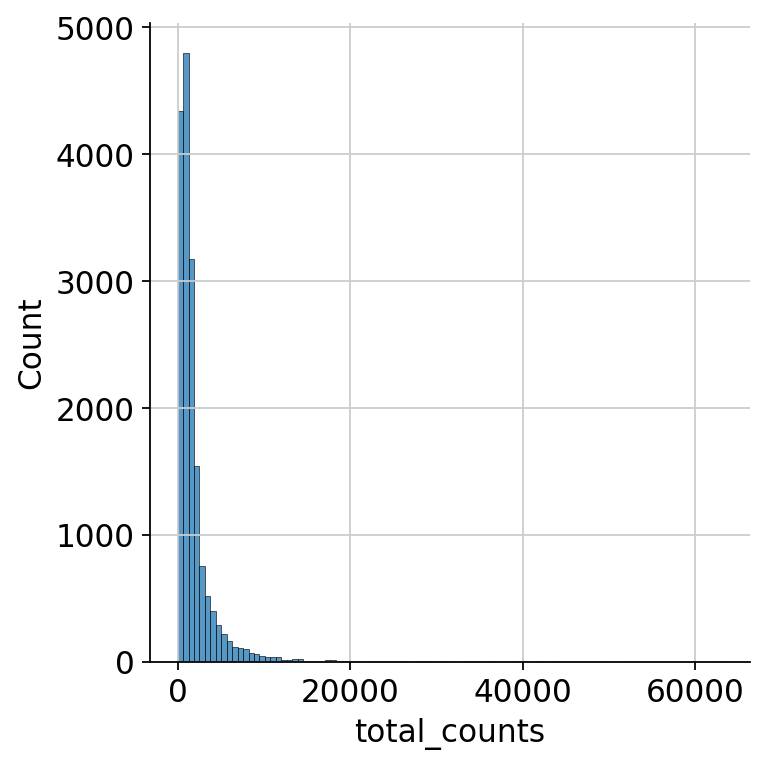

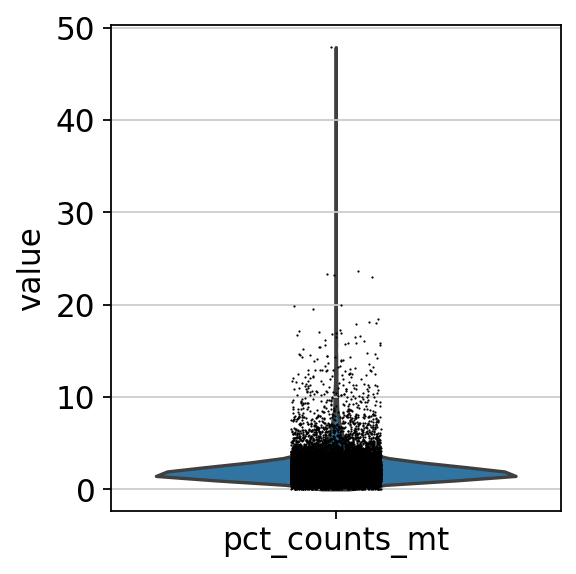

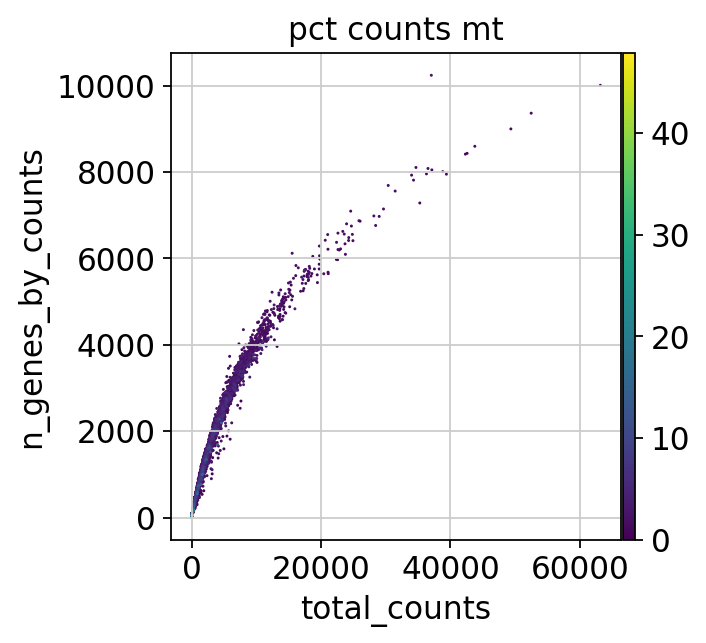

In [6]:
p1 = sns.displot(adata.obs["total_counts"], bins=100, kde=False)
# sc.pl.violin(adata, 'total_counts')
p2 = sc.pl.violin(adata, "pct_counts_mt")
p3 = sc.pl.scatter(adata, "total_counts", "n_genes_by_counts", color="pct_counts_mt")

这些图表显示，一些序列具有相对较高的线粒体计数比例，这通常与细胞降解有关。但由于每个细胞的计数数量足够高，并且大多数细胞的线粒体序列百分比低于20％，因此我们仍然可以处理数据。基于这些图表，现在可以定义手动阈值以过滤细胞。相反，我们将展示基于MAD的自动阈值和过滤的QC。

首先，我们定义一个函数，该函数接受一个`metric`，即`.obs`中的一列和过滤策略中仍然允许的MAD数（`nmad`）。

In [7]:
def is_outlier(adata, metric: str, nmads: int):
    M = adata.obs[metric]
    outlier = (M < np.median(M) - nmads * median_abs_deviation(M)) | (
        np.median(M) + nmads * median_abs_deviation(M) < M
    )
    return outlier

现在，我们将此函数应用于`log1p_total_counts`，`log1p_n_genes_by_counts`和`pct_counts_in_top_20_genes` QC协变量，每个协变量的阈值为5 MAD。

In [8]:
adata.obs["outlier"] = (
    is_outlier(adata, "log1p_total_counts", 5)
    | is_outlier(adata, "log1p_n_genes_by_counts", 5)
    | is_outlier(adata, "pct_counts_in_top_20_genes", 5)
)
adata.obs.outlier.value_counts()

False    16065
True       869
Name: outlier, dtype: int64

`pct_counts_Mt`使用3 MAD进行过滤。此外，将线粒体百分比超过8％的细胞过滤掉。

In [9]:
adata.obs["mt_outlier"] = is_outlier(adata, "pct_counts_mt", 3) | (
    adata.obs["pct_counts_mt"] > 8
)
adata.obs.mt_outlier.value_counts()

False    15240
True      1694
Name: mt_outlier, dtype: int64

现在，我们根据这两列附加的数据过滤AnnData对象。

In [10]:
print(f"Total number of cells: {adata.n_obs}")
adata = adata[(~adata.obs.outlier) & (~adata.obs.mt_outlier)].copy()

print(f"Number of cells after filtering of low quality cells: {adata.n_obs}")

Total number of cells: 16934
Number of cells after filtering of low quality cells: 14814


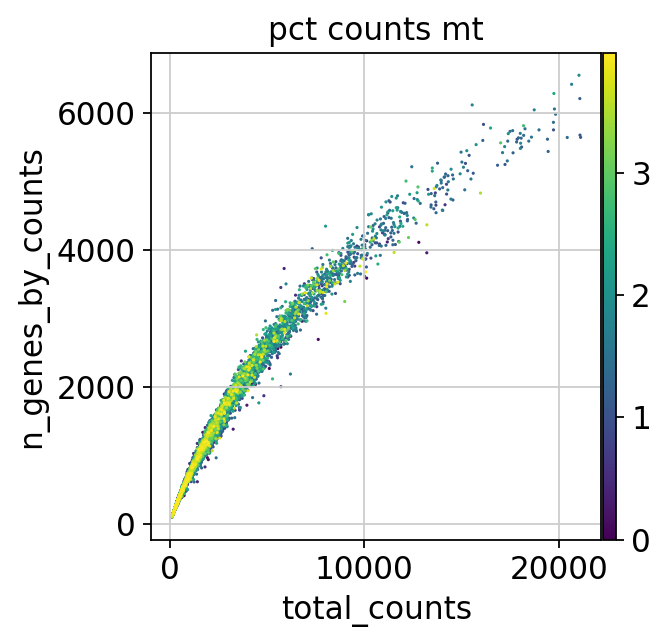

In [11]:
p1 = sc.pl.scatter(adata, "total_counts", "n_genes_by_counts", color="pct_counts_mt")

## 环境RNA的校正

对于基于液滴的单细胞RNA测序实验，存在一定量的背景mRNA，它与包含细胞的液滴一起分布并与其一起测序。这样做的净效应是产生一个背景污染，代表的是来自液滴中包含的细胞之外的表达，而是包含细胞的溶液。

基于液滴的单细胞RNA-seq生成基因的唯一分子标识符（UMI）计数，并旨在识别每个基因和每个细胞的分子数。它假定每个液滴都包含来自单个细胞的mRNA。双细胞、空液滴和无细胞RNA可能会违反这个假设。无细胞mRNA分子代表存在于稀释中的背景mRNA。这些分子分布在液滴中并与其一起测序。这种细胞外mRNA在输入溶液中的污染通常称为“Soup”，它是由细胞溶解产生的。


<img src="https://www.sc-best-practices.org/_images/ambient_rna.jpeg" alt="Ambient RNA Overview" class="bg-primary mb-1" width="800px">

在基于液滴的测序技术中，液滴可以包含环境RNA或双细胞（捕获多个细胞的液滴）。污染的环境RNA与细胞内的本地mRNA一起进行barcode和计数，导致混淆的计数。


无细胞mRNA分子，也称为环境RNA，可能会混淆观察到的计数数量，并且可以视为背景污染。对于基于液滴的scRNA-seq数据集进行无细胞mRNA校正非常重要，因为它可能会扭曲我们下游分析中的数据解释。通常，Soup对每个输入溶液都有所不同，并且取决于数据集中单个细胞的表达模式。去除环境mRNA的方法，如SoupX[[Young和Behjati，2020](https://www.sc-best-practices.org/preprocessing_visualization/quality_control.html#id135)]和DecontX[[Yang *et al.*，2020](https://www.sc-best-practices.org/preprocessing_visualization/quality_control.html#id133)]，旨在估算Soup的组成并根据Soup的表达来校正计数表。

首先，SoupX计算Soup的概要文件。它根据未过滤的Cellranger矩阵从空液滴中估算环境mRNA表达谱。接下来，SoupX估算细胞特异性污染分数。最后，它根据环境mRNA表达谱和估计的污染来校正表达矩阵。

SoupX的输出是修改后的计数矩阵，可以用于任何下游分析工具。

现在，我们加载运行SoupX所需的Python和R包。

In [12]:
import anndata2ri
import logging

import rpy2.rinterface_lib.callbacks as rcb
import rpy2.robjects as ro

rcb.logger.setLevel(logging.ERROR)
ro.pandas2ri.activate()
anndata2ri.activate()

%load_ext rpy2.ipython

In [13]:
%%R
library(SoupX)


    an issue that caused a segfault when used with rpy2:
    https://github.com/rstudio/reticulate/pull/1188
    Make sure that you use a version of that package that includes
    the fix.
    

可以在没有聚类信息的情况下运行SoupX，但是，正如Young和Behjati所指出的那样，如果提供了基本聚类，则结果会更好。SoupX可以与cellranger生成的默认聚类或手动定义的聚类一起使用。在本笔记本中，我们将展示后者，因为SoupX的结果对使用的聚类不太敏感。

现在，我们创建AnnData对象的副本，对其进行归一化、降维处理并在处理后的副本上计算默认的Leiden聚类。下一章将更详细地介绍聚类。现在我们只需要知道，Leiden聚类为数据集中的细胞提供了分区（社区）。我们将获得的聚类保存为`soupx_groups`并删除AnnData对象的副本，以在笔记本中节省一些内存。

首先，我们生成AnnData对象的副本，对其进行归一化和log1p转换。此时，我们使用简单的移位对数归一化。有关不同归一化技术的更多信息可以在归一化章节中找到。

In [14]:
adata_pp = adata.copy()
sc.pp.normalize_per_cell(adata_pp)
sc.pp.log1p(adata_pp)

接下来，我们计算数据的主成分以获得较低的维度表示。然后，使用该表示生成数据的邻域图，并在KNN图上运行Leiden聚类。我们将聚类添加为`soupx_groups`到`.obs`并将其保存为向量。

In [15]:
sc.pp.pca(adata_pp)
sc.pp.neighbors(adata_pp)
sc.tl.leiden(adata_pp, key_added="soupx_groups")

# Preprocess variables for SoupX
soupx_groups = adata_pp.obs["soupx_groups"]

我们现在可以删除AnnData对象的副本，因为我们生成了一个可以在soupX中使用的聚类向量。

In [16]:
del adata_pp

接下来，我们保存过滤后的cellranger输出的细胞名称、基因名称和数据矩阵。SoupX需要一个形状为features x barcodes的矩阵，因此我们必须转置`.X`。

In [17]:
cells = adata.obs_names
genes = adata.var_names
data = adata.X.T

SoupX还需要原始的基因按单元格矩阵，通常在cellranger输出中称为`raw_feature_bc_matrix.h5`。我们与之前类似地加载此矩阵，使用scanpy运行`.var_names_make_unique()`并转置相应的`.X`。

In [18]:
adata_raw = sc.read_10x_h5(
    filename="raw_feature_bc_matrix.h5",
    backup_url="https://figshare.com/ndownloader/files/39546217",
)
adata_raw.var_names_make_unique()
data_tod = adata_raw.X.T

/mnt/sdd/singleron_product/chenjin/miniconda3/envs/scanpy/lib/python3.10/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [19]:
del adata_raw

现在我们已经准备好运行SoupX了。输入是形状为“barcodes x cells”的经过过滤的cellranger矩阵、形状为`barcodes x droplets`的cellranger液滴原始表格、基因和细胞名称以及通过简单的Leiden聚类获得的聚类。输出将是校正后的计数矩阵。

我们首先从液滴表格和细胞表格构建所谓的`SoupChannel`。接下来，我们向SoupChannel对象添加元数据，这些元数据可以是任何形式的`DataFrame`。我们在这里添加

In [20]:
%%R -i data -i data_tod -i genes -i cells -i soupx_groups -o out 

# specify row and column names of data
rownames(data) = genes
colnames(data) = cells
# ensure correct sparse format for table of counts and table of droplets
data <- as(data, "sparseMatrix")
data_tod <- as(data_tod, "sparseMatrix")

# Generate SoupChannel Object for SoupX 
sc = SoupChannel(data_tod, data, calcSoupProfile = FALSE)

# Add extra meta data to the SoupChannel object
soupProf = data.frame(row.names = rownames(data), est = rowSums(data)/sum(data), counts = rowSums(data))
sc = setSoupProfile(sc, soupProf)
# Set cluster information in SoupChannel
sc = setClusters(sc, soupx_groups)

# Estimate contamination fraction
sc  = autoEstCont(sc, doPlot=FALSE)
# Infer corrected table of counts and rount to integer
out = adjustCounts(sc, roundToInt = TRUE)

SoupX成功推断出校正计数，现在我们可以将其存储为附加层。在所有后续分析步骤中，我们希望使用SoupX校正后的计数矩阵，因此我们使用soupX校正矩阵覆盖`.X`。

In [21]:
adata.layers["counts"] = adata.X
adata.layers["soupX_counts"] = out.T
adata.X = adata.layers["soupX_counts"]

接下来，我们还会过滤掉在至少20个细胞中未检测到的基因，因为这些基因是没有信息的。

In [22]:
print(f"Total number of genes: {adata.n_vars}")

# Min 20 cells - filters out 0 count genes
sc.pp.filter_genes(adata, min_cells=20)
print(f"Number of genes after cell filter: {adata.n_vars}")

Total number of genes: 36601
Number of genes after cell filter: 20214


## 双细胞检测

双倍体是指在同一细胞barcode下被测序的两个细胞，例如，如果它们被捕获在相同的液滴中。这就是为什么我们到现在为止使用了`barcode`而不是`cell`这个术语。如果由相同的细胞类型（但来自不同的个体）形成，则称为同型双倍体，否则称为异型双倍体。从计数矩阵中无法识别同型双倍体，因此通常认为它们是无害的，因为可以使用细胞哈希或SNP来识别它们。因此，它们的识别不是双倍体检测方法的主要目标。

由不同细胞类型或状态形成的双倍体称为异型双倍体。它们的识别非常重要，因为它们很可能被错误分类，并可能导致扭曲的下游分析步骤。因此，双倍体检测和去除通常是初始预处理步骤。双倍体可以通过其高读数和检测特征来识别，也可以使用创建人工双倍体的方法并将其与数据集中存在的细胞进行比较。双倍体检测方法计算效率高，存在多个软件包可用于此任务。

[Xi and Li, 2021]对九种不同的双倍体检测方法进行了基准测试，并评估了它们的计算效率和双倍体检测准确性。他们还在其基准测试的补充中评估了scDblFinder，该方法实现了最高的双倍体检测准确性和良好的计算效率和稳定性。

在本教程中，我们将展示scDblFinder R软件包。scDblFinder随机选择两个液滴，并通过对它们的基因表达谱求平均值创建人工双倍体。然后，双倍体分数被定义为每个液滴在主成分空间中的k最近邻图中人工双倍体的分数。


<img src="https://www.sc-best-practices.org/_images/doublet_detection.jpeg" alt="双细胞检测描述" class="bg-primary mb-1" width="800px">

双倍体是包含多个细胞的液滴。常见的双倍体检测方法通过随机子采样细胞对并平均其基因表达谱以获得双倍体计数。这些人工双倍体与其余呼叫一起投影到较低维的主成分空间中。双倍体检测方法基于k最近邻图中人工双倍体邻居的数量计算双倍体分数。

我们首先加载一些额外的python和R软件包。

In [23]:
%%R
library(Seurat)
library(scater)
library(scDblFinder)
library(BiocParallel)

In [24]:
data_mat = adata.X.T

现在，我们可以使用data_mat作为输入，在SingleCellExperiment中使用scDblFinder启动双倍体检测。scBblFinder向sce的colData添加了几列。其中三列可能对分析有用：

- `sce$scDblFinder.score`：最终的双倍体分数（分数越高，该细胞越可能是双倍体）
- `sce$scDblFinder.ratio`：细胞邻域中人工双倍体的比率
- `sce$scDblFinder.class`：分类（双倍体或单体）

我们只输出类参数，并将其存储在`.obs`中的AnnData对象中。可以以类似的方式向AnnData对象添加其他参数。

In [25]:
%%R -i data_mat -o doublet_score -o doublet_class

set.seed(123)
sce = scDblFinder(
    SingleCellExperiment(
        list(counts=data_mat),
    ) 
)
doublet_score = sce$scDblFinder.score
doublet_class = sce$scDblFinder.class

scDblFinder输出一个分类，其中包含分类`Singlet`（1）和`Doublet`（2）。我们在`.obs`中将其添加到AnnData对象中。

In [26]:
adata.obs["scDblFinder_score"] = doublet_score
adata.obs["scDblFinder_class"] = doublet_class
adata.obs.scDblFinder_class.value_counts()

singlet    11904
doublet     2910
Name: scDblFinder_class, dtype: int64

我们建议暂时保留已识别的双倍体，并在可视化期间检查双倍体。

在下游聚类期间，重新评估质量控制和选择的参数以潜在地过滤更多或更少的细胞可能是有用的。现在，我们可以保存数据集并继续进行归一化章节。

In [27]:
adata.write("s4d8_quality_control.h5ad")

## 要点

1. 应基于中位数绝对偏差进行低质量细胞的过滤，设定宽松的截断值，以避免对较小亚群体产生偏见。
2. 基于特征的过滤对下游任务没有益处。
3. 可以使用像scDblFinder这样的工具有效检测双倍体。
4. 不应在代表多批次的聚合scRNA-seq数据上运行双倍体检测方法。